# Speed comparison of image filters when using dask
Benchmark of image filters (population bilateral and mean) on large images using dask to parallize the workload using threading. Numba is used to compile the filter functions and releasing the GIL.

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from skimage.io import imread, imshow
from skimage.morphology import square

45 Mega pixels


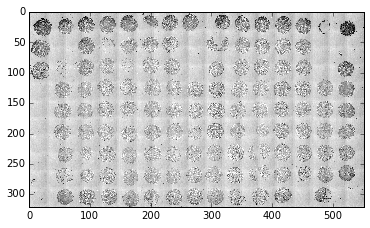

In [84]:
img = imread('data/experiment--2015_05_04_19_28_38_equalized/stitched--U00--V00--C00--Z00.png')
imshow(img[::16, ::16])
mpixels = int(img.shape[0] * img.shape[1] * 1e-6)
print(mpixels, 'Mega pixels')

## parallel function mapping with dask
From [@cowlicks](https://github.com/cowlicks): https://github.com/scikit-image/scikit-image/pull/1493

In [85]:
from math import ceil
from multiprocessing import cpu_count
import dask.array as da

def _get_chunks(shape, ncpu):
    """
    Split the array into equal sized chunks based on the number of
    available processors. The last chunk in each dimension absorbs the
    remainder array elements if the number of cpus does not divide evenly into
    the number of array elements.
    >>> _get_chunks((4, 4), 4)
    ((2, 2), (2, 2))
    >>> _get_chunks((4, 4), 2)
    ((2, 2), (4,))
    >>> _get_chunks((5, 5), 2)
    ((2, 3), (5,))
    >>> _get_chunks((2, 4), 2)
    ((1, 1), (4,))
    """
    chunks = []
    nchunks_per_dim = int(ceil(ncpu ** (1./len(shape))))

    used_chunks = 1
    for i in shape:
        if used_chunks < ncpu:
            regular_chunk = i // nchunks_per_dim
            remainder_chunk = regular_chunk + (i % nchunks_per_dim)

            if regular_chunk == 0:
                chunk_lens = (remainder_chunk,)
            else:
                chunk_lens = ((regular_chunk,) * (nchunks_per_dim - 1) +
                              (remainder_chunk,))
        else:
            chunk_lens = (i,)

        chunks.append(chunk_lens)
        used_chunks *= nchunks_per_dim
    return tuple(chunks)


def apply_chunks(function, array, chunks=None, depth=0, mode=None,
                 extra_arguments=(), extra_keywords={}):
    """Map a function in parallel across an array.
    Split an array into possibly overlapping chunks of a given depth and
    boundary type, call the given function in parallel on the chunks, combine
    the chunks and return the resulting array.
    Parameters
    ----------
    function : function
        Function to be mapped which takes an array as an argument.
    array : numpy array
        Array which the function will be applied to.
    chunks : int, tuple, or tuple of tuples, optional
        A single integer is interpreted as the length of one side of a square
        chunk that should be tiled across the array.  One tuple of length
        ``array.ndim`` represents the shape of a chunk, and it is tiled across
        the array.  A list of tuples of length ``ndim``, where each sub-tuple
        is a sequence of chunk sizes along the corresponding dimension. If
        None, the array is broken up into chunks based on the number of
        available cpus. More information about chunks is in the documentation
        `here <https://dask.pydata.org/en/latest/array-design.html>`_.
    depth : int, optional
        Integer equal to the depth of the added boundary cells. Defaults to
        zero.
    mode : 'reflect', 'periodic', 'wrap', 'nearest', optional
        type of external boundary padding
    extra_arguments : tuple, optional
        Tuple of arguments to be passed to the function.
    extra_keywords : dictionary, optional
        Dictionary of keyword arguments to be passed to the function.
    """
    if chunks is None:
        shape = array.shape
        ncpu = cpu_count()
        chunks = _get_chunks(shape, ncpu)

    if mode == 'wrap':
        mode = 'periodic'

    def wrapped_func(arr):
        return function(arr, *extra_arguments, **extra_keywords)

    darr = da.from_array(array, chunks=chunks)
    return darr.map_overlap(wrapped_func, depth, boundary=mode).compute()

## Population bilateral filter
Counts number of neighbors which are in the range of [g-s0, g+s1] where g is the center pixel.

In [86]:
def pop_bilateral(img, selem, s0=10, s1=10):
    """Simple pop bilateral filter.
    
    Parameters
    ----------
    img : 2d array
        Padded image.
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    img = img.astype(np.int16) # avoid overrun when calculating diff
    pad = selem.shape[0]//2 # square selem for now
    selem_size = 2*pad+1 # always center in center
    out = np.zeros(img.shape, dtype=np.uint8) # nopython, nogil
    img = np.pad(img, pad, mode='edge') # nopython, nogil
    _pop_bilateral(img, selem_size, out, s0, s1)
    return out

@jit(nogil=True, nopython=True)
def _pop_bilateral(img, selem_size, out, s0=10, s1=10):
    """
    Parameters
    ----------
    img : 2d array
        Padded image.
    selem_size : int
        Size of square selem.
    out : 2d array
        Array to store result to (nopython, nogil).
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            val = img[i+pad, j+pad]
            o = 0
            for ii in range(selem_size):
                for jj in range(selem_size):
                    diff = img[i+ii, j+jj] - val
                    if diff >= -s0 and diff <= s1:
                        o += 1
            out[i, j] = o # cheaper than accessing array in each inner loop

## 2 x 1d implementation of mean filter
Implementation from scipy: http://www.phi-node.com/2013/06/faster-morphological-image-filters-in.html

In [87]:
def mean(img, selem):
    img = img.astype(np.uint32)
    out = np.empty(img.shape, dtype=np.uint8)
    pad = selem.shape[0]//2 # square selem for now
    img = np.pad(img, pad, mode='edge')
    rows = np.zeros(img.shape, dtype=np.uint32) # size of padded
    selem_size = 2*pad+1
    _mean(img, selem_size, rows, out)
    return out


@jit(nopython=True, nogil=True)
def _mean(img, selem_size, rows, out):
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix):
            for ii in range(selem_size):
                rows[i, j] += img[i+ii, j]
    # 2n instead of 2^2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            o = 0
            for jj in range(selem_size):
                o += rows[i, j+jj]
            out[i, j] = o // selem_size**2

## pop speed comparison

In [88]:
# numba
%time pop_nb = pop_bilateral(img, square(9))

CPU times: user 14.5 s, sys: 531 ms, total: 15 s
Wall time: 15.2 s


In [89]:
# numba parallel with dask threading, depth == overlap == selem.shape//2
%time pop_da = apply_chunks(pop_bilateral, img, depth=4, extra_arguments=(square(9),))

CPU times: user 22.9 s, sys: 960 ms, total: 23.9 s
Wall time: 7.58 s


[]

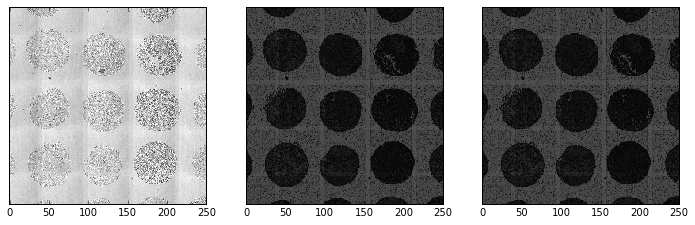

In [90]:
# view image where the stitch/seam is
nchunks_per_dim = int(ceil(cpu_count() ** (1./len(img.shape))))
first_seam = [x//nchunks_per_dim for x in img.shape]
size = 1000
step = 8
mask = np.index_exp[first_seam[0]-size:first_seam[0]+size:step, first_seam[1]-size:first_seam[1]+size:step]

plt.figure(figsize=(12,4))
plt.subplot(131)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(132)
imshow(pop_nb[mask]).axes.set_yticks([])
plt.subplot(133)
imshow(pop_da[mask]).axes.set_yticks([]);

## mean speed comparison

In [91]:
# numba mean
%time mean_nb = mean(img, square(21))

CPU times: user 5.53 s, sys: 979 ms, total: 6.51 s
Wall time: 6.67 s


In [92]:
# numba parallel with dask threading
%time mean_da = apply_chunks(mean, img, depth=10, extra_arguments=(square(21),))

CPU times: user 8.31 s, sys: 1.47 s, total: 9.77 s
Wall time: 3.02 s


[]

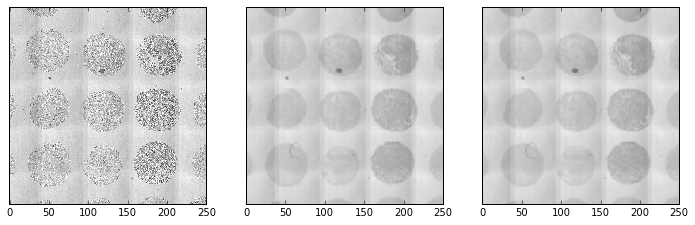

In [93]:
plt.figure(figsize=(12,4))
plt.subplot(131)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(132)
imshow(mean_nb[mask]).axes.set_yticks([])
plt.subplot(133)
imshow(mean_da[mask]).axes.set_yticks([]);

## seams with and without overlap

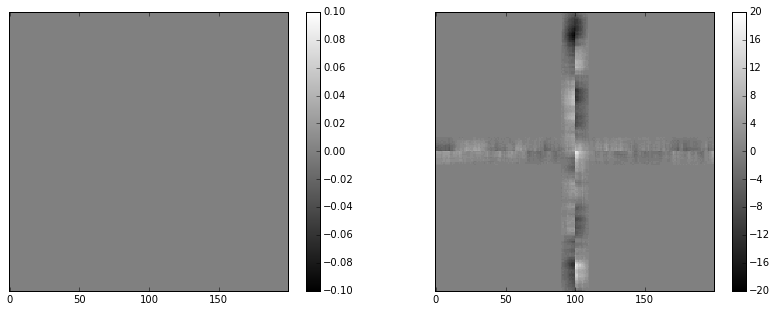

In [94]:
diff_overlap = mean_nb.astype(np.int) - mean_da.astype(np.int)
# without overlap
mean_no_overlap = apply_chunks(mean, img, extra_arguments=(square(21),))
diff_no_overlap = mean_nb.astype(np.int) - mean_no_overlap.astype(np.int)

nchunks_per_dim = int(ceil(cpu_count() ** (1./len(img.shape))))
first_seam = [x//nchunks_per_dim for x in img.shape]
size = 100
step = 1
mask = np.index_exp[first_seam[0]-size:first_seam[0]+size:step, first_seam[1]-size:first_seam[1]+size:step]

plt.figure(figsize=(14,5))
plt.subplot(121)
imshow(diff_overlap[mask], cmap="gray").axes.set_yticks([])
plt.subplot(122)
imshow(diff_no_overlap[mask], cmap="gray").axes.set_yticks([]);